In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import scipy.stats as ss
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
plt.rcParams['font.family'] = 'DejaVu Sans'

In [9]:
import yfinance as yf

prices = yf.download('HDFCBANK.NS','2018-07-16','2022-07-14')

prices.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-07-16,1089.699951,1095.025024,1081.875000,1084.425049,1058.393433,4508668
2018-07-17,1081.625000,1090.500000,1081.625000,1088.375000,1062.248413,3180962
2018-07-18,1093.500000,1110.000000,1086.824951,1088.099976,1061.980103,8730136
2018-07-19,1091.500000,1096.750000,1085.500000,1093.050049,1066.811279,2652388
2018-07-20,1093.050049,1101.425049,1085.550049,1094.525024,1068.251099,5003482


In [10]:
prices.index = prices.index.to_period(freq='d')
print(prices.index)

price = prices['Adj Close']
price.head()

dX = price.diff() 
ret_log = np.log(price).diff()
ret = price.pct_change()
ret = ret.dropna()

PeriodIndex(['2018-07-16', '2018-07-17', '2018-07-18', '2018-07-19',
             '2018-07-20', '2018-07-23', '2018-07-24', '2018-07-25',
             '2018-07-26', '2018-07-27',
             ...
             '2022-06-30', '2022-07-01', '2022-07-04', '2022-07-05',
             '2022-07-06', '2022-07-07', '2022-07-08', '2022-07-11',
             '2022-07-12', '2022-07-13'],
            dtype='period[D]', name='Date', length=986, freq='D')


In [11]:
def calc_VaR(r, VaR_fun, L_history=252, level=0.05):
    VaR = np.full(r.size, np.nan)
    
    for i in range(L_history, len(r)):
        history = r[i - L_history: i]
        VaR[i] = VaR_fun(history, level)
        
    return pd.Series(data=VaR, index=r.index, name=VaR_fun.__name__)

## Calculating VaR using Generalized normal distribution 

In [12]:
def calculate_VaR_gennorm(ret, alpha=0.05):

    params_norm = ss.gennorm.fit(ret)
    
    return ss.gennorm.ppf(alpha, *params_norm)

VaR_gennorm = calc_VaR(ret, calculate_VaR_gennorm, L_history=252, level=0.05)

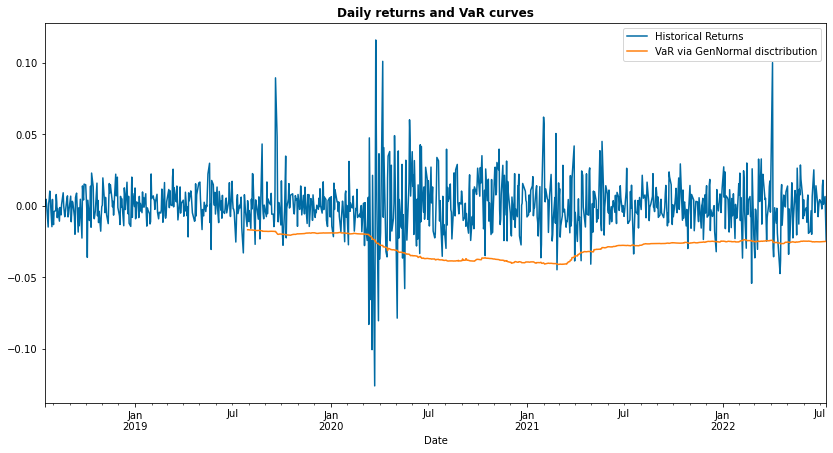

In [13]:
ret.plot(figsize=(14,7))
VaR_gennorm.plot(figsize=(14,7))
plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
            'VaR via GenNormal disctribution'])

plt.show()


## Calculate VaR using EGARCH(2, 1 , 2) 

In [14]:
from arch import arch_model 

dist = 'skewstudent' 

mdl = arch_model(100 * ret,
                    mean='constant', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='EGARCH', p=2, o=1, q=2, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist=dist) # dist = Normal, t, skewstudent, ged

res = mdl.fit()
res

Iteration:      1,   Func. Count:     11,   Neg. LLF: 30079.99059621397
Iteration:      2,   Func. Count:     25,   Neg. LLF: 54748.13455885439
Iteration:      3,   Func. Count:     39,   Neg. LLF: 76874.20922821033
Iteration:      4,   Func. Count:     52,   Neg. LLF: 43478.430092016584
Iteration:      5,   Func. Count:     65,   Neg. LLF: 70301.97890062706
Iteration:      6,   Func. Count:     78,   Neg. LLF: 14875.86679218788
Iteration:      7,   Func. Count:     90,   Neg. LLF: 19119.21654792945
Iteration:      8,   Func. Count:    101,   Neg. LLF: 26971.936190327906
Iteration:      9,   Func. Count:    113,   Neg. LLF: 1770.8131361084133
Iteration:     10,   Func. Count:    123,   Neg. LLF: 1770.201153109172
Iteration:     11,   Func. Count:    133,   Neg. LLF: 1770.8770223210208
Iteration:     12,   Func. Count:    144,   Neg. LLF: 1770.1475466668721
Iteration:     13,   Func. Count:    154,   Neg. LLF: 1770.1470920659376
Iteration:     14,   Func. Count:    164,   Neg. LLF: 1770

                           Constant Mean - EGARCH Model Results                          
Dep. Variable:                         Adj Close   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                EGARCH   Log-Likelihood:               -1770.15
Distribution:      Standardized Skew Student's t   AIC:                           3558.29
Method:                       Maximum Likelihood   BIC:                           3602.33
                                                   No. Observations:                  985
Date:                           Fri, Jul 15 2022   Df Residuals:                      984
Time:                                   12:31:22   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

## EGARCH

In [15]:
def calculate_VaR_egarch(returns, alpha):
    
    scaling_const = 10.0/ returns.std()

    dist = 'skewstudent'
    am = arch_model(scaling_const * returns,
                    mean='constant', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='EGARCH', p=2, o=1, q=2, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist=dist) # dist = Normal, t, skewstudent, ged

    res = am.fit(update_freq=0, disp='off', tol=1e-01)

    forecasts = res.forecast(horizon=1)

    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    if dist == 'Normal':
        q = am.distribution.ppf(alpha)
    elif dist == 't' or dist == 'ged':
        q = am.distribution.ppf(alpha, res.params[-1:])
    elif dist == 'skewstudent':
        q = am.distribution.ppf(alpha, res.params[-2:])

    return_egarch_forecast = cond_mean / scaling_const
    VaR_egarch_forecast = (cond_mean + np.sqrt(cond_var) * q) / scaling_const

    return VaR_egarch_forecast

VaR_egarch = calc_VaR(ret, calculate_VaR_egarch, L_history=252, level=0.05)


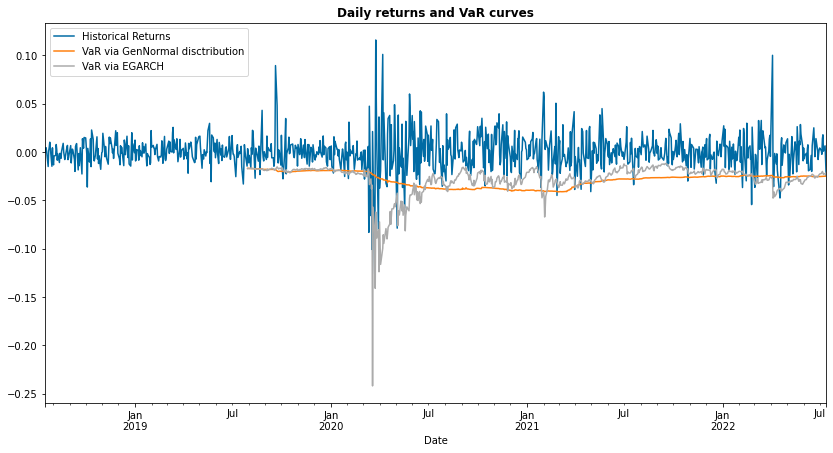

In [16]:
ret.plot(figsize=(14,7))
VaR_gennorm.plot(figsize=(14,7))
VaR_egarch.plot(figsize=(14,7))
plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
            'VaR via GenNormal disctribution',
           'VaR via EGARCH'])

plt.show()

## GARCH+

In [17]:
def calculate_VaR_pot(ret, alpha=0.05):
    
    u = ret.quantile(0.2)
    ret_tail = ret[ret <= u]

    c, loc, scale = ss.genpareto.fit(-ret_tail, loc=0)
    
    var_hs_evt = u - scale / c * ((alpha/(ret <= u).mean())**(-c) - 1)
    
    return var_hs_evt

In [18]:
def calculate_VaR_FHS(returns, alpha):

    scaling_const = 10.0 / returns.std()

    mdl = arch_model(scaling_const * returns,
                    mean='HARX', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=1, o=1, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist='normal')

    res = mdl.fit(disp='off')

   # get Standartized residuals
    stand_residuals = res.resid / res.conditional_volatility
    stand_residuals = stand_residuals.dropna()


    # forecast mean and variance one step ahead
    forecasts = res.forecast(horizon=1)
    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    # conditional stand_residuals
    conditional_sr = cond_mean + np.sqrt(cond_var) * stand_residuals
    conditional_sr = conditional_sr / scaling_const

    # calculate VaR as quantile
    VaR_FHS = calculate_VaR_pot(conditional_sr, alpha)

    return VaR_FHS

VaR_FHS_EVT = calc_VaR(ret, calculate_VaR_FHS, L_history=252, level=0.05)

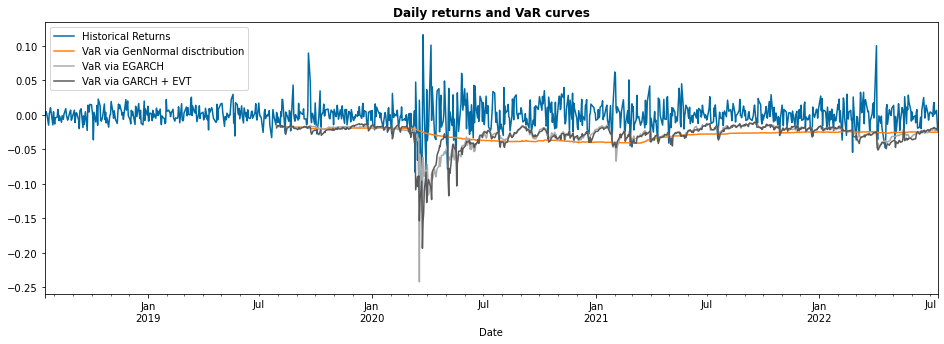

In [19]:
fig = plt.figure(figsize=(16, 5))

ret.plot()
VaR_gennorm.plot()
VaR_egarch.plot()
VaR_FHS_EVT.plot()

plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
           'VaR via GenNormal disctribution',
            'VaR via EGARCH',
           'VaR via GARCH + EVT'])

plt.show()

## Backtesting

In [20]:
def calc_hits(returns, VaRs):
    return ((VaRs - returns).dropna() > 0).values

def zone(p):
    if p > 0.05:
        return 'green'
    elif p > 0.0001:
        return 'yellow'
    else:
        return 'red'
    
def backtest_VaR(r, VaR, level, L=None):
    # to skip starting NaNs
    if L is None:
        L = (~VaR.isna()).to_numpy().nonzero()[0][0];
    r = r[L:]
    VaR = VaR[L:]
    
    hits = calc_hits(r, VaR)    
    
    p_value_two_sided = ss.binom_test(sum(hits), len(hits), 1-level, alternative = 'two-sided')
    p_value_conservative = ss.binom_test(sum(hits), len(hits), 1-level, alternative = 'greater')
    print(f'Backtesting {VaR.name}:')
    print(f'The proportion of hits is {(sum(hits)/len(hits))*100:.3}% instead of expected {(1-level)*100:.3}%')
    print(f'Two-sided p-val {p_value_two_sided:.3}, one-sided: {p_value_conservative:.3}')
    print(f'{zone(p_value_two_sided)} zone\n')

backtest_VaR(ret, VaR_gennorm, 1-0.05)
backtest_VaR(ret, VaR_egarch, 1-0.05)
backtest_VaR(ret, VaR_FHS_EVT, 1-0.05)

Backtesting calculate_VaR_gennorm:
The proportion of hits is 5.59% instead of expected 5.0%
Two-sided p-val 0.445, one-sided: 0.252
green zone

Backtesting calculate_VaR_egarch:
The proportion of hits is 5.73% instead of expected 5.0%
Two-sided p-val 0.351, one-sided: 0.203
green zone

Backtesting calculate_VaR_FHS:
The proportion of hits is 5.73% instead of expected 5.0%
Two-sided p-val 0.351, one-sided: 0.203
green zone



## Conclusion

For a HDFCBANK stock, the most appropriate model for determining Value at Risk (VaR) is the combined GARCH + EVT model. This model showed the best proportion of VaR breakdowns - 5.73%, which almost coincides with the expected value of 5%. Also the p-value of the model is significant (0.351>0.05). The EGARCH model performed well: p-value > 0.05, but the proportion of breakdowns is  5.73% - a deviation of 0.79% from the expected one.